In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt

torch.random.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


Link to the data:
https://drive.google.com/file/d/1ITE-wx5pIenrk-c0v0ovUyu6-V1OOv26/view?usp=sharing

_(this is a subset of "skin-cancer-mnist-ham10000")_


In [2]:
df = pd.read_csv("data/HAM2000/metadata.csv")
full_name = {
    "bcc": "Basal cell carcinoma",
    "bkl": "Benign keratosis-like lesions",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
}
df["dx_full"] = df["dx"].map(full_name.get)
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_full
0,HAM_0006518,ISIC_0027618,nv,follow_up,35.0,male,back,Melanocytic nevi
1,HAM_0004666,ISIC_0029165,nv,follow_up,55.0,male,upper extremity,Melanocytic nevi
2,HAM_0006455,ISIC_0029690,nv,follow_up,50.0,male,lower extremity,Melanocytic nevi
3,HAM_0003653,ISIC_0030139,nv,histo,45.0,male,back,Melanocytic nevi
4,HAM_0001330,ISIC_0026818,nv,histo,20.0,female,abdomen,Melanocytic nevi


In [3]:
transfo = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]
)
dataset = torchvision.datasets.ImageFolder(root="data/HAM2000/", transform=transfo)
dataset_loader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=True, num_workers=1
)
class_names = [full_name[name] for name in dataset.find_classes("data/HAM2000/")[0]]


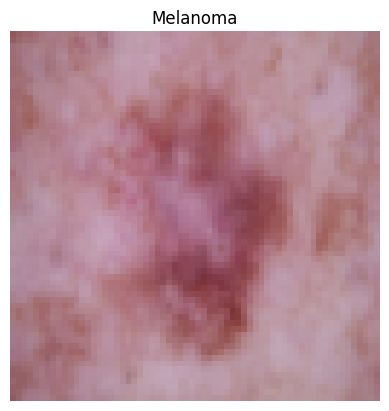

In [4]:
for image, label in dataset_loader:
    plt.imshow(image[0].permute(1, 2, 0))
    plt.title(class_names[label[0]])
    plt.axis("off")
    plt.show()
    break


In [5]:
class SkinNet(nn.Module):
    def __init__(self, hidden_size=64):
        super(SkinNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, stride=2)
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1)
        self.conv4 = nn.Conv2d(32, 32, 5, stride=1)
        self.conv5 = nn.Conv2d(32, 32, 5, stride=1)
        self.fc1 = nn.Linear(14 * 14 * 32, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        # print(x.shape)
        x = x.view(-1, 14 * 14 * 32)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


In [6]:
model = SkinNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.CrossEntropyLoss()

num_epochs = 60
losses = []


In [7]:
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for image, label in dataset_loader:
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss /= len(dataset_loader)
    losses.append(running_loss)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {running_loss:.4f}")


Epoch [1/60], Loss: 1.3862
Epoch [2/60], Loss: 1.3819
Epoch [3/60], Loss: 1.3388
Epoch [4/60], Loss: 1.3059
Epoch [5/60], Loss: 1.2814
Epoch [6/60], Loss: 1.2662
Epoch [7/60], Loss: 1.2486
Epoch [8/60], Loss: 1.2275
Epoch [9/60], Loss: 1.2110
Epoch [10/60], Loss: 1.1840
Epoch [11/60], Loss: 1.1803
Epoch [12/60], Loss: 1.1762
Epoch [13/60], Loss: 1.1716
Epoch [14/60], Loss: 1.1726
Epoch [15/60], Loss: 1.1698
Epoch [16/60], Loss: 1.1607
Epoch [17/60], Loss: 1.1567
Epoch [18/60], Loss: 1.1660
Epoch [19/60], Loss: 1.1540
Epoch [20/60], Loss: 1.1558
Epoch [21/60], Loss: 1.1572
Epoch [22/60], Loss: 1.1510
Epoch [23/60], Loss: 1.1455
Epoch [24/60], Loss: 1.1483
Epoch [25/60], Loss: 1.1488
Epoch [26/60], Loss: 1.1496
Epoch [27/60], Loss: 1.1472
Epoch [28/60], Loss: 1.1398
Epoch [29/60], Loss: 1.1530
Epoch [30/60], Loss: 1.1530
Epoch [31/60], Loss: 1.1481
Epoch [32/60], Loss: 1.1642
Epoch [33/60], Loss: 1.1428
Epoch [34/60], Loss: 1.1358
Epoch [35/60], Loss: 1.1413
Epoch [36/60], Loss: 1.1333
E

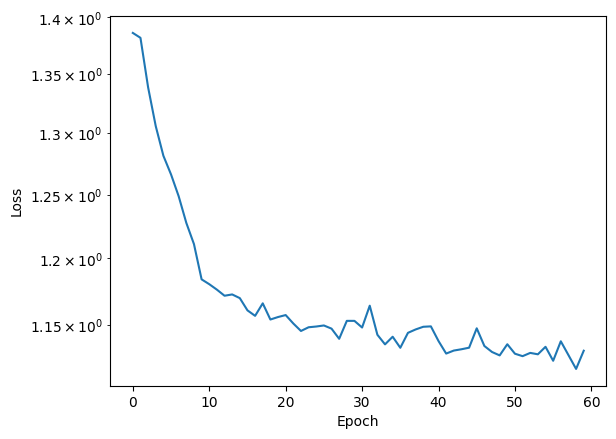

In [8]:
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


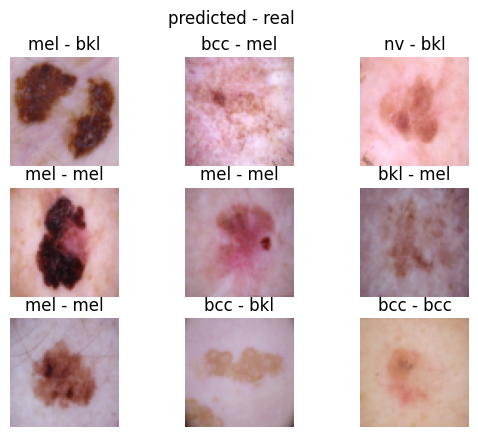

In [9]:
small_class_names = dataset.find_classes("data/HAM2000/")[0]
for images, labels in dataset_loader:
    predictions = model(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].numpy().swapaxes(0, 2).swapaxes(0, 1))
        pred_class = small_class_names[torch.argmax(predictions[i])]
        real_class = small_class_names[labels[i]]
        ax.set_title(f"{pred_class} - {real_class}")
        plt.axis("off")
    plt.suptitle("predicted - real")
    plt.show()
    break


In [10]:
correct = 0
total = 0
for images, labels in dataset_loader:
    predictions = model(images)
    total += labels.size(0)
    correct += (torch.argmax(predictions, dim=1) == labels).sum().item()

print(f"Accuracy: {100*correct/total:.2f} %")


Accuracy: 61.15 %
